<a href="https://colab.research.google.com/github/meti-94/TextClassification/blob/main/SingleStockTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git -q

     |████████████████████████████████| 234 kB 6.4 MB/s 
     |████████████████████████████████| 176 kB 46.3 MB/s 
     |████████████████████████████████| 57.6 MB 1.2 MB/s 
     |████████████████████████████████| 1.8 MB 40.2 MB/s 
     |████████████████████████████████| 124 kB 45.1 MB/s 
     |████████████████████████████████| 147 kB 31.2 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
     |████████████████████████████████| 2.4 MB 42.7 MB/s 
     |████████████████████████████████| 153 kB 49.0 MB/s 
     |████████████████████████████████| 195 kB 48.5 MB/s 
     |████████████████████████████████| 90.8 MB 283 bytes/s 
     |████████████████████████████████| 448 kB 49.8 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 1.1 MB 36.4 MB/s 
     |████████████████████████████████| 3.6 MB 28.0 MB/s 
     |████████████████████████████████| 271 kB 53.8 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████

In [8]:
from finrl.apps import config
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
from datetime import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [6]:
def read_data(path):
    hist = pd.read_csv(path, parse_dates=True)
    hist = hist[hist.Timestamp>=1388521800]
    hist['date'] = hist['Timestamp'].apply(lambda item:datetime.fromtimestamp(item))
    hist.set_index('date', inplace=True)
    hist.dropna(inplace=True)
    return hist

def resampling(hist, timeframe='1min'):
    ohlc = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume_(BTC)':'sum'
    }
    df = hist.resample(timeframe, origin='end_day').apply(ohlc)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'Open':'open', 'High':'high', 'Close':'close', 'Low':'low', 'Volume_(BTC)':'volume'}, inplace=True)
    df['date'] = df['date'].astype(str)
    df['tic'] = ['BTC' for _ in range(len(df))]
    df['day'] = [i%5 for i in range(len(df))]
    return df   
hist = read_data('/content/drive/MyDrive/kaggle_dataset/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
hist = hist['2014-01-01' :'2021-03-30']
hist = resampling(hist, timeframe='D')
df = hist

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1823, 8)
Successfully added vix
Successfully added turbulence index


In [10]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [11]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2014-01-02,BTC,732.01,757.99,729.01,754.90,7903.038301,1.0,0.513782,775.835491,711.064509,100.000000,66.666667,100.000000,743.450000,743.450000,14.23,0.0
1,2014-01-03,BTC,751.88,798.70,742.50,784.19,15134.172831,2.0,1.562941,809.350233,704.709767,100.000000,100.000000,100.000000,757.030000,757.030000,13.76,0.0
2,2014-01-06,BTC,828.83,948.00,826.07,905.00,24067.042492,0.0,8.400712,925.084076,679.689257,100.000000,156.587191,100.000000,802.386667,802.386667,13.55,0.0
3,2014-01-07,BTC,905.23,995.00,876.00,915.56,25901.389228,1.0,11.327710,959.495829,677.612742,100.000000,135.731314,100.000000,818.554286,818.554286,12.92,0.0
4,2014-01-08,BTC,915.56,943.00,780.00,780.00,34154.459703,2.0,6.661009,947.038964,680.431036,54.800819,23.683737,38.925707,813.735000,813.735000,12.87,0.0
5,2014-01-09,BTC,784.50,849.79,765.00,823.95,26210.364808,3.0,5.508577,939.750261,689.989739,60.750757,-3.530812,32.183687,814.870000,814.870000,12.89,0.0
6,2014-01-10,BTC,823.95,848.00,779.78,824.76,25299.469800,4.0,4.652651,933.763274,697.954726,60.849016,2.995430,32.183687,815.859000,815.859000,12.14,0.0
7,2014-01-13,BTC,894.70,905.00,826.46,841.52,12159.345801,2.0,7.168749,938.603016,714.432369,59.421119,49.184608,34.799890,826.517692,826.517692,13.28,0.0
8,2014-01-14,BTC,841.52,843.60,783.11,824.00,19363.714080,3.0,5.327803,934.034362,718.641353,56.898773,-13.546430,17.604009,826.337857,826.337857,12.28,0.0
9,2014-01-15,BTC,824.00,837.00,800.00,815.99,9730.124914,4.0,3.396149,929.564429,721.731571,55.778933,-12.171596,17.604009,825.648000,825.648000,12.28,0.0


In [12]:
processed_full.sort_values(['date','tic'],ignore_index=True).tail(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
1810,2021-03-17,BTC,55413.23,57150.00,53221.00,57127.98,7720.773149,4.0,3051.346731,61837.691982,42297.886018,61.113118,74.526036,14.449061,52161.940667,44871.618000,19.230000,0.207861
1811,2021-03-18,BTC,57079.16,59244.98,54124.00,59244.98,5854.798012,0.0,3129.511848,62643.039136,42720.536864,62.716614,97.604003,21.156922,52540.721000,45261.045167,21.580000,0.330618
1812,2021-03-19,BTC,59235.60,60083.25,57000.00,57524.96,5493.120625,1.0,3017.878798,62954.826429,43528.437571,60.615805,100.927726,23.715298,52816.865667,45621.242667,20.950001,0.748917
1813,2021-03-22,BTC,58038.65,58632.52,55500.00,57425.64,3627.440501,4.0,2680.504472,63206.317638,46523.724362,60.232799,66.745163,10.349283,53267.170333,46711.766833,18.879999,0.070404
1814,2021-03-23,BTC,57393.65,58461.78,53715.00,54262.78,6570.362893,0.0,2275.173323,62932.360532,47386.578468,56.349489,39.695376,2.396768,53210.667667,47105.283833,20.299999,2.076739
1815,2021-03-24,BTC,54249.05,55866.44,52933.03,54233.85,5001.192174,1.0,1929.370477,62791.824452,47932.868548,56.315135,23.444063,0.946121,53099.929667,47461.071500,21.200001,0.053881
1816,2021-03-25,BTC,54267.89,57207.33,51638.76,52349.40,6874.214748,2.0,1486.128697,62381.194383,48747.271617,54.092872,12.938777,4.753569,53039.933333,47800.005833,19.809999,0.991900
1817,2021-03-26,BTC,52291.72,53271.59,50360.00,51355.59,6668.912147,3.0,1042.645266,62072.803038,49301.593962,52.952880,-22.605052,0.947877,53119.601333,48118.446000,18.860001,0.401307
1818,2021-03-29,BTC,55946.79,56573.04,54677.51,55804.36,2074.410637,1.0,981.075478,61125.039038,51711.056962,57.113164,37.272459,12.953798,53915.662333,49316.047833,20.740000,3.051882
1819,2021-03-30,BTC,55822.98,58402.68,54892.42,57670.58,5363.655852,2.0,1104.926211,61240.759938,51861.956062,58.805280,58.878863,19.970756,54305.441667,49719.447000,19.610001,0.290028


In [13]:
train = data_split(processed_full, '2014-01-01','2019-12-30')
trade = data_split(processed_full, '2019-12-30','2021-03-30')
print(len(train))
print(len(trade))

1505
314


In [14]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
1500,2019-12-20,BTC,7312.33,7372.12,7000.00,7152.85,5890.150193,1.0,-216.265923,7717.238116,6798.768884,43.565215,-47.098110,17.241634,7312.158000,8056.563333,12.51,0.325071
1501,2019-12-23,BTC,7136.01,7543.27,7124.52,7543.27,3835.810260,4.0,-139.578708,7691.133310,6783.759690,47.646910,55.852805,1.309110,7274.820000,8026.295500,12.61,1.264039
1502,2019-12-24,BTC,7543.27,7692.98,7247.86,7322.70,6665.968354,0.0,-120.652291,7693.103530,6784.140470,45.770106,59.041985,7.937096,7274.353333,8024.343000,12.67,0.527695
1503,2019-12-26,BTC,7255.55,7266.81,7110.73,7189.80,1505.818294,2.0,-105.458895,7681.627364,6783.439636,44.655744,-42.171316,1.135215,7288.348667,7965.316333,12.65,0.230259
1504,2019-12-27,BTC,7189.82,7432.00,7150.00,7187.00,3120.054271,3.0,-100.914876,7636.200714,6791.710286,44.631639,-14.549331,8.864639,7289.552333,7925.613000,13.43,0.007648


In [15]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2014-01-02,BTC,732.01,757.99,729.01,754.90,7903.038301,1.0,0.513782,775.835491,711.064509,100.000000,66.666667,100.000000,743.450000,743.450000,14.23,0.0
1,2014-01-03,BTC,751.88,798.70,742.50,784.19,15134.172831,2.0,1.562941,809.350233,704.709767,100.000000,100.000000,100.000000,757.030000,757.030000,13.76,0.0
2,2014-01-06,BTC,828.83,948.00,826.07,905.00,24067.042492,0.0,8.400712,925.084076,679.689257,100.000000,156.587191,100.000000,802.386667,802.386667,13.55,0.0
3,2014-01-07,BTC,905.23,995.00,876.00,915.56,25901.389228,1.0,11.327710,959.495829,677.612742,100.000000,135.731314,100.000000,818.554286,818.554286,12.92,0.0
4,2014-01-08,BTC,915.56,943.00,780.00,780.00,34154.459703,2.0,6.661009,947.038964,680.431036,54.800819,23.683737,38.925707,813.735000,813.735000,12.87,0.0


In [16]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [17]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [18]:
env_train, _ = e_train_gym.get_sb_env()

In [19]:
agent = DRLAgent(env = env_train)

In [20]:

model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [21]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 179        |
|    iterations         | 100        |
|    time_elapsed       | 2          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -1.45      |
|    explained_variance | -1.05      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -7.41      |
|    reward             | -0.9308806 |
|    std                | 1.03       |
|    value_loss         | 15.7       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 211       |
|    iterations         | 200       |
|    time_elapsed       | 4         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -1.45     |
|    explained_variance | 2.98e-07  |
|    learning_rate      | 0.0007  

In [22]:
data_risk_indicator = processed_full[(processed_full.date<'2019-12-30') & (processed_full.date>='2014-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [23]:
insample_risk_indicator.vix.describe()

count    1505.000000
mean       14.961708
std         4.045220
min         9.140000
25%        12.290000
50%        13.950000
75%        16.490000
max        40.740002
Name: vix, dtype: float64

In [24]:
insample_risk_indicator.vix.quantile(0.996)

30.408559844970696

In [25]:
insample_risk_indicator.turbulence.describe()

count    1505.000000
mean        0.928695
std         2.975403
min         0.000000
25%         0.003600
50%         0.095465
75%         0.568596
max        47.316742
Name: turbulence, dtype: float64

In [26]:
insample_risk_indicator.turbulence.quantile(0.996)

23.658840384059832

In [27]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [28]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2019-12-30,BTC,7303.95,7524.46,7274.43,7373.31,2578.586403,1.0,-61.989725,7569.857683,6813.851317,46.686939,60.212815,15.904570,7263.511667,7827.233667,14.82,0.249586
1,2019-12-31,BTC,7374.61,7384.90,7195.35,7195.35,3742.154103,2.0,-62.392237,7568.201796,6812.748204,44.985077,1.254479,11.374963,7251.486667,7794.521500,13.78,0.390196
2,2020-01-02,BTC,7161.51,7237.35,7150.00,7176.23,1114.711226,4.0,-64.704701,7558.033785,6807.954215,44.846302,-31.350803,6.707486,7238.400667,7723.829167,12.47,0.018801
3,2020-01-03,BTC,7169.70,7184.94,6900.00,6946.56,4003.390169,0.0,-82.178475,7556.033975,6779.884025,42.649668,-117.010890,6.772129,7226.646333,7686.106167,14.02,0.631633
4,2020-01-06,BTC,7354.22,7495.00,7310.00,7347.52,2708.293113,3.0,-34.387423,7591.539271,6842.615729,47.322448,86.383978,9.396315,7223.777000,7585.279000,13.85,1.486921


In [29]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [30]:
df_account_value.shape

(314, 2)

In [31]:
df_account_value.tail()

,date,account_value
309,2021-03-23,9.682493e+06
310,2021-03-24,9.677344e+06
311,2021-03-25,9.341911e+06
312,2021-03-26,9.165013e+06
313,2021-03-29,9.956894e+06


In [32]:
df_actions.tail()

,date,actions
308,2021-03-22,[0]
309,2021-03-23,[0]
310,2021-03-24,[0]
311,2021-03-25,[0]
312,2021-03-26,[0]


In [33]:
print("==============Get Backtest Results===========")
now = datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return           5.324732
Cumulative returns      8.956894
Annual volatility       0.680932
Sharpe ratio            3.061898
Calmar ratio           22.022575
Stability               0.872024
Max drawdown           -0.241785
Omega ratio             1.738747
Sortino ratio           5.342604
Skew                         NaN
Kurtosis                     NaN
Tail ratio              1.461456
Daily value at risk    -0.077516
dtype: float64


In [34]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (313, 8)
Annual return          0.128488
Cumulative returns     0.161995
Annual volatility      0.336334
Sharpe ratio           0.529864
Calmar ratio           0.346457
Stability              0.428201
Max drawdown          -0.370862
Omega ratio            1.117407
Sortino ratio          0.730232
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.815244
Daily value at risk   -0.041667
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (313, 8)


Start date,2019-12-30
End date,2021-03-29
Total months,14
,Backtest
Annual return,532.473%
Cumulative returns,895.689%
Annual volatility,68.093%
Sharpe ratio,3.06
Calmar ratio,22.02
Stability,0.87
Max drawdown,-24.179%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.18,2020-02-13,2020-03-11,2020-04-27,53
1,22.75,2021-01-08,2021-01-28,2021-02-09,23
2,21.18,2021-02-22,2021-03-01,2021-03-12,15
3,17.10,2020-08-18,2020-09-24,2020-10-22,48
4,14.42,2020-05-08,2020-05-12,2020-06-02,18


Stress Events,mean,min,max
New Normal,0.83%,-13.82%,19.85%


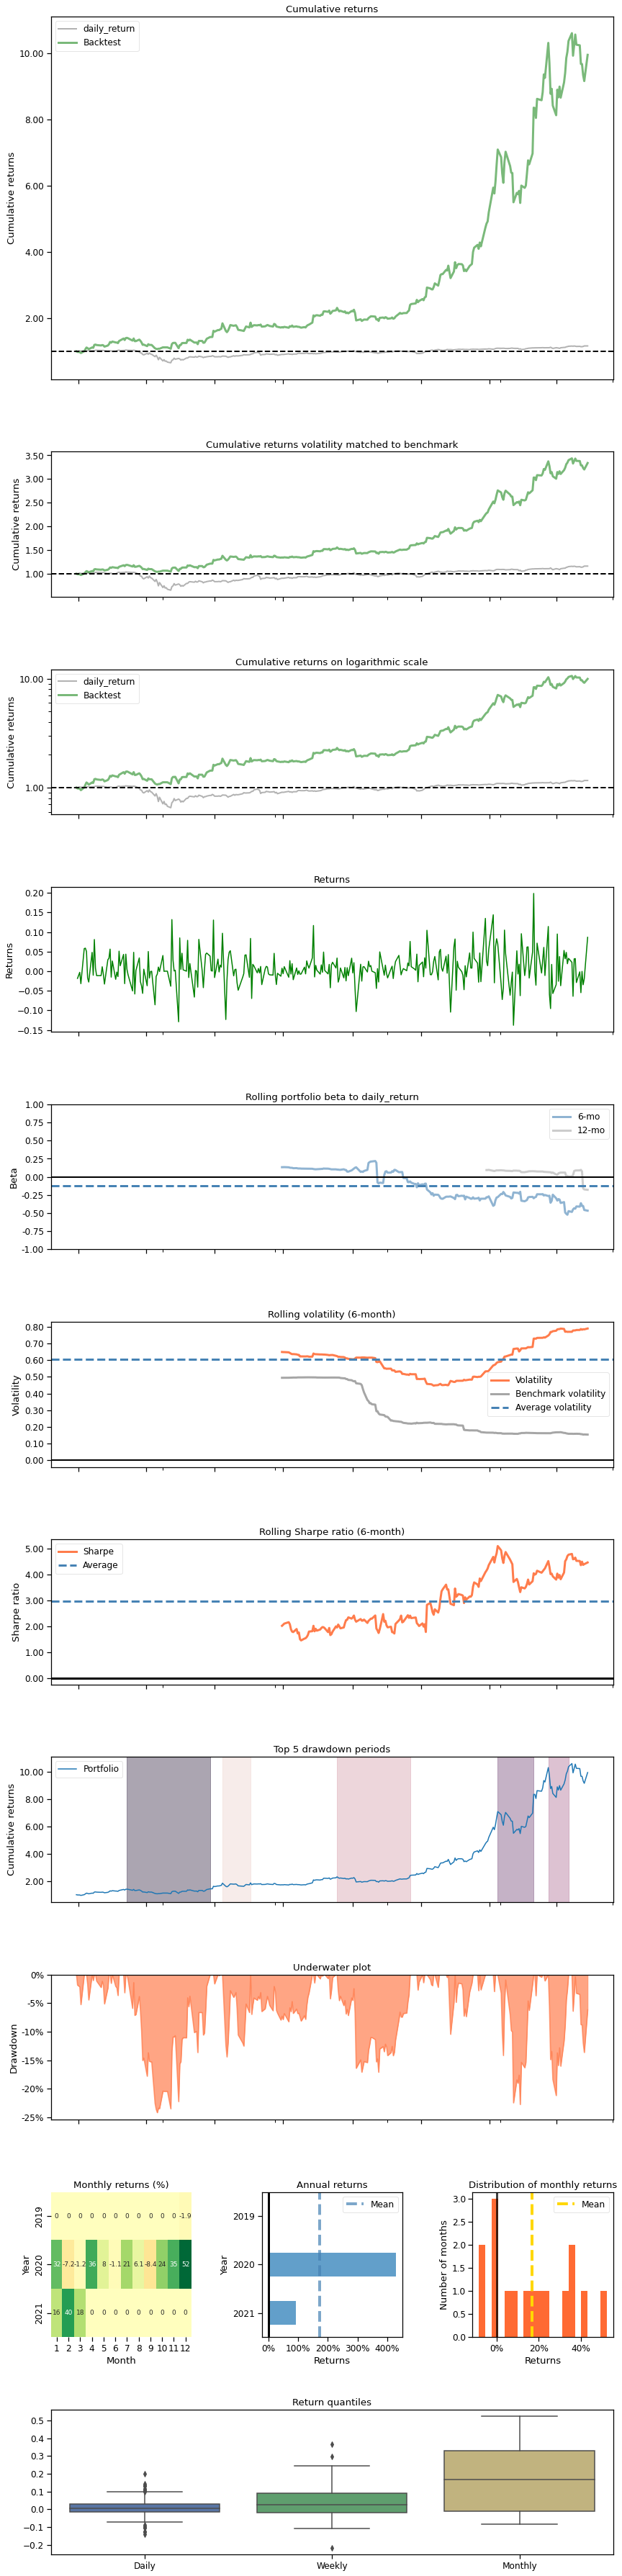

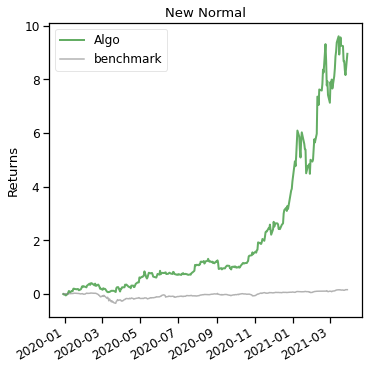

In [35]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])